## Anscombeの例
平均や標準偏差、相関係数といった基本統計量は重要ですが、散布図の外観が全く異なっていてもこれらの基本統計量が(ほぼ)同一となることは起こりえます。このような例として**[Anscombeの例 (Anscombe's quartet)](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%B3%E3%82%B9%E3%82%B3%E3%83%A0%E3%81%AE%E4%BE%8B)** が有名です。Seabornを用いると、このAnscombeの4つの例は簡単に描画することができます。
> [Anscombe’s quartet — seaborn 0.10.1 documentation](https://seaborn.pydata.org/examples/anscombes_quartet.html)

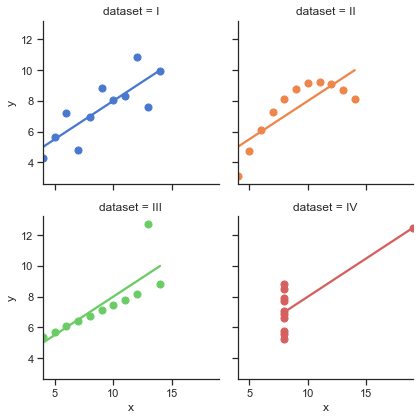

In [1]:
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=3,
           scatter_kws={"s": 50, "alpha": 1})

この4つの例において、基本統計量や回帰直線はほぼ同じとなっています (具体的な数値の詳細は[Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%B3%E3%82%B9%E3%82%B3%E3%83%A0%E3%81%AE%E4%BE%8B)に記載されています)。

このAnscombeの例は地道に調整をしたものでしょうが、より自由な形でかつ自動的にこのような例を見つける手法が研究されています。今回は2017年にpublishされた摂動と焼きなまし法を用いる手法について紹介します。

## Same Stats, Different Graphs

論文は
>  Matejka J, Fitzmaurice G. Same stats, different graphs: generating datasets with varied appearance and identical statistics through simulated annealing. *CHI'17 Conference proceedings*. 2017.

です。論文を紹介するWebサイト ([The Datasaurus Dozen](https://www.autodeskresearch.com/publications/samestats))は必見と言えるほど興味深い図が多いので先に見ることをお勧めします。

以下では、データセットを基本統計量を保ったまま目的の形状に移動させる方法を実装していきます。著者実装とデータは上記のWebサイトにありますが、原理を理解したかったので再実装をしています。

### ライブラリのimport
まず使用するライブラリをimportします。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

### 初期データセットの作成
変換元となるデータセットをランダムに生成します。

In [3]:
np.random.seed(100) # set random seed
N = 100 # sample size
X_init = 100*np.random.rand(N, 2)

# 2D Gaussian distribution 
# mean = [0, 0]
# cov = [[2, 1],[1, 2]]
# X_init = 50 + 10 * np.random.multivariate_normal(mean, cov, N) 

データセットの統計量 (平均 `mean`、標準偏差 `SD`、相関係数 `Corr.`)を計算する関数と、散布図と回帰直線をplotし、統計量を図のtitleとして表示する関数を作成します。

In [4]:
def get_statistics(X):
    x = X[:, 0]
    y = X[:, 1]
    xm = x.mean()
    ym = y.mean()
    xsd = x.std()
    ysd = y.std()
    pc = np.corrcoef(x, y)[0, 1]
    
    return np.array([xm, ym, xsd, ysd, pc])

def plot_with_statistics(X, plottype="scatter"):
    xm, ym, xsd, ysd, pc = get_statistics(X)
    sns.set_style('darkgrid')
    plt.title("X mean : "+'{:.2f}'.format(xm) 
              + ", Y mean : "+'{:.2f}'.format(ym)\
              + "\nX SD : "+'{:.2f}'.format(xsd)\
              + ", Y SD : "+'{:.2f}'.format(ysd)\
              + "\nCorr. : "+'{:.2f}'.format(pc), fontsize=16, loc='left')
    if plottype == "scatter":
        plt.scatter(X[:, 0], X[:, 1], color='k', alpha=0.5)
    elif plottype == "regplot":
        sns.regplot(X[:, 0], X[:, 1], scatter_kws={"color":'k', "alpha":0.5})
    plt.xlabel(r"$x$"); plt.ylabel(r"$y$")

ここで生成したデータセットの統計量を確認してみましょう。

In [5]:
xm, ym, xsd, ysd, pc = get_statistics(X_init)

print ("X mean: ", xm)
print ("X SD: ", xsd)
print ("Y mean: ", ym)
print ("Y SD: ", ysd)
print ("Pearson correlation: ", pc)

X mean:  48.835157263702186
X SD:  28.854420177156825
Y mean:  50.32301746413461
Y SD:  28.96516729392245
Pearson correlation:  0.10235266202058498


初期データセットの散布図を描画します。

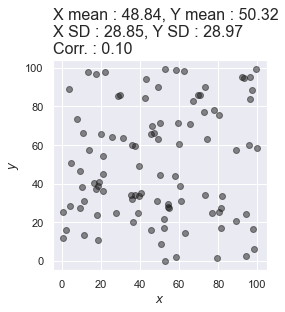

In [6]:
plt.figure(figsize=(4, 4.5))
plot_with_statistics(X_init)
plt.tight_layout()
plt.show()

### 目標図形の作成
今回は円とバツ印、縞模様に近づけます。それぞれの形を表す配列(`X_circle`, `X_cross`, `X_stripe`)を作成します。このとき、点の数はデータセットのサンプルサイズと異なっていても問題はありません。

In [7]:
# circle
theta = np.arange(0, 2*np.pi, 0.1)
xc = 50
yc = 50
r = 40
X_circle = np.array([xc + r*np.cos(theta), yc + r*np.sin(theta)]).T # target

# cross
min_pos = 0
max_pos = 100
pos_cross = np.arange(min_pos, max_pos)
X_cross = np.concatenate([np.array([pos_cross, pos_cross]),
                          np.array([pos_cross, max_pos-pos_cross])], axis=1).T

# stripe
X_stripe = np.concatenate([np.array([pos_cross, max_pos-pos_cross]),
                           np.array([pos_cross, max_pos-pos_cross])+25,
                           np.array([pos_cross, max_pos-pos_cross])-25], axis=1).T

作成した目標図形を描画します。

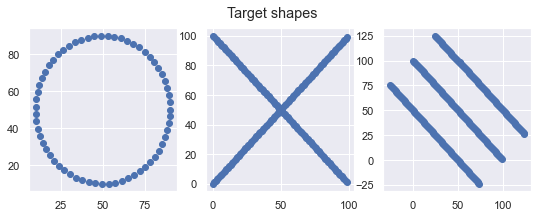

In [8]:
plt.figure(figsize=(9,3))
plt.suptitle('Target shapes')
plt.subplot(1,3,1)
plt.scatter(X_circle[:, 0], X_circle[:, 1])
plt.subplot(1,3,2)
plt.scatter(X_cross[:, 0], X_cross[:, 1])
plt.subplot(1,3,3)
plt.scatter(X_stripe[:, 0], X_stripe[:, 1])
plt.show()

### 初期データセットを目標図形に近づける
まず、データセット(`X`)と目標図形 (`X_target`)の間の距離を計算する関数を作成します。

In [9]:
def compute_dist(X, X_target):
    return np.sum(np.min(cdist(X, X_target), axis=1))

次に焼きなまし法で用いる関数を定義します。焼きなまし法の疑似コードは[Wikipedia](https://ja.wikipedia.org/wiki/%E7%84%BC%E3%81%8D%E3%81%AA%E3%81%BE%E3%81%97%E6%B3%95)に掲載されています。また、手前味噌ですが、[焼きなまし法(Simulated Annealing)と2-Opt法による巡回セールスマン問題の解法](https://salad-bowl-of-knowledge.github.io/hp/processing/2017/12/03/simulated_annealing.html)という記事も参考になると思います (Processingによる実装です)。

焼きなまし法は、各状態に対応するエネルギーや距離などの量を最小化する場合に適応されます。新しい状態の目標図形との距離 `dist_new`が古い状態の距離 `dist_old`より小さくなる場合には確率1で遷移し、そうでない場合は確率 $\exp((e−e' )/T)$で遷移します。ただし、$e$は`dist_old`, $e'$は`dist_new`, $T$は温度に対応します。

また、温度 $T$は$\alpha^r$(ただし、$0<\alpha<1$)とし、$r$は0から大きくなっていくとします。

In [10]:
def probability(dist_old, dist_new, temp):
    if dist_old >= dist_new:
        prob = 1
    else:
        prob = np.exp((dist_old - dist_new)/temp)
    return prob

# 0 < alpha < 1
def temperature(iteration, max_iter, alpha=0.85):
    return np.power(alpha, iteration/max_iter)

正しく遷移確率が減少していくかを描画します。

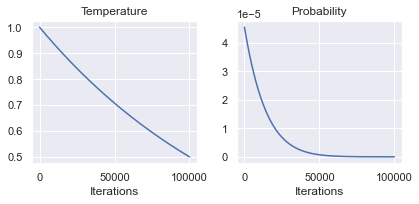

In [11]:
max_iter = 1e5
delta_dist = -10
iterations = np.arange(max_iter)
temp = temperature(iterations, max_iter, alpha=0.5)
prob = np.exp(delta_dist/temp)

plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.title("Temperature")
plt.plot(temp)
plt.xlabel("Iterations")

plt.subplot(1,2,2)
plt.title("Probability")
plt.plot(prob)
plt.xlabel("Iterations")
plt.tight_layout()
plt.show()

点の移動を行うためのメインとなる関数を作成します。最適化の過程ではまず正規分布に従う摂動をデータセットに加えます。次に統計量の変化の絶対値が一定の値(`eps`)以下であれば、目標図形との距離を計算し、距離の変化に応じて焼きなまし法によりデータセットを更新します。

In [12]:
def move_points(X_init, X_target, update_scale=0.1, max_iter=200000, eps=1e-2):
    X_old = X_init # initialize
    dist_old = compute_dist(X_old, X_target)
    statistics_init = get_statistics(X_init)
    distlist = []
    
    for iteration in tqdm(range(max_iter)):    
        # pertubation
        X_new = X_old + update_scale * np.random.randn(N,2)
        
        # check statistics
        statistics_new = get_statistics(X_new)
        dvalues = statistics_init - statistics_new
        
        if all(np.abs(dvalues) < eps):
            # compute distance between samples and targets
            dist_new = compute_dist(X_new, X_target)
            
            # Simulated annealing
            temp = temperature(iteration, max_iter)
            prob = probability(dist_old, dist_new, temp)

            if np.random.rand() <= prob:
                # Update
                X_old = X_new
                dist_old = dist_new
                distlist.append(dist_new)
                
    return X_new, distlist

それでは`move_points`関数により、初期データセットを目標の形に近づけてみましょう。まず、円の場合からです。

In [13]:
X1_opt, distlist1 = move_points(X_init, X_circle)

次にバツ印の場合です。

In [14]:
X2_opt, distlist2 = move_points(X_init, X_cross)

最後に縞模様の場合です。

In [15]:
X3_opt, distlist3 = move_points(X_init, X_stripe)

目標図形との距離の変化を描画してみましょう。距離が減少に向かっていなければパラメータを調整する必要があります。

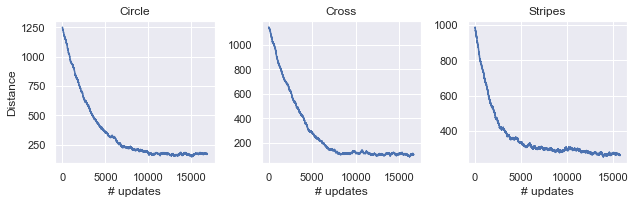

In [16]:
plt.figure(figsize=(9, 3))
plt.subplot(1,3,1)
plt.title("Circle")
plt.plot(np.array(distlist1))
plt.xlabel("# updates")
plt.ylabel("Distance")

plt.subplot(1,3,2)
plt.title("Cross")
plt.plot(np.array(distlist2))
plt.xlabel("# updates")

plt.subplot(1,3,3)
plt.title("Stripes")
plt.plot(np.array(distlist3))
plt.xlabel("# updates")
plt.tight_layout()
plt.show()

収束を確認したら、最後に初期データセットと移動後のデータセットの散布図を可視化します。

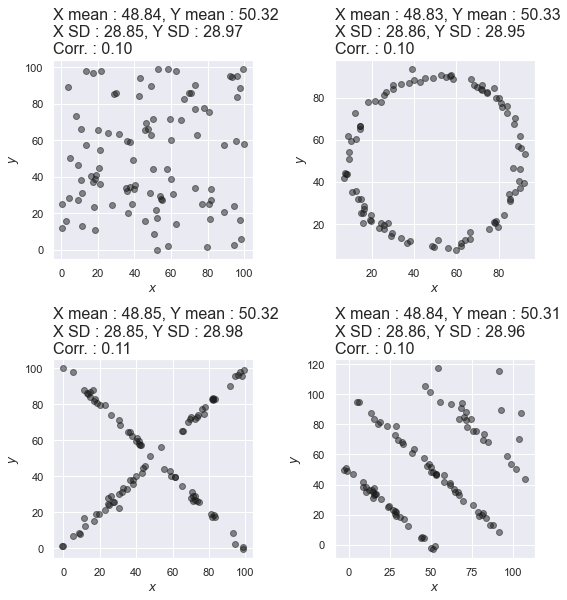

In [17]:
plt.figure(figsize=(8, 8.5))
plt.subplot(2,2,1)
plot_with_statistics(X_init)
plt.subplot(2,2,2)
plot_with_statistics(X1_opt)
plt.subplot(2,2,3)
plot_with_statistics(X2_opt)
plt.subplot(2,2,4)
plot_with_statistics(X3_opt)
plt.tight_layout()
plt.show()

このように、ほぼ同じ統計量であっても散布図の外観が全く違うデータセットを生成することができます。

特に最後の縞模様は[Simpson’s Paradox](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%83%B3%E3%83%97%E3%82%BD%E3%83%B3%E3%81%AE%E3%83%91%E3%83%A9%E3%83%89%E3%83%83%E3%82%AF%E3%82%B9)と呼ばれるもので、母集団全体での相関と、母集団における各群内での相関が異なるというものです。ここでは全体の相関が正なのに、3つの各群では相関は明らかに負です。回帰直線を描画すると次のようになります。

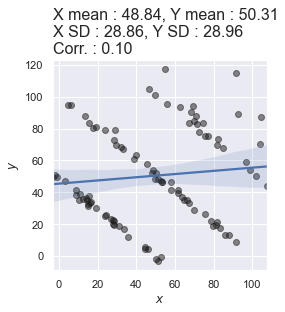

In [18]:
plt.figure(figsize=(4,4.5))
plot_with_statistics(X3_opt, plottype="regplot")
plt.tight_layout()
plt.show()

この例では相関はほぼ0に等しいですが、強い相関があってもこのような散布図を生み出すことはできます (`X_init`を2次元のGaussian分布に変えて試してみてください)。

## データの可視化において注意する点
これまで見てきたように同じ基本統計量であっても生データの外観が全く異なる場合が数多く存在します。このような場合に重要なことは、当然ながら**生データを確認する**ことです。また、グラフにするときは棒グラフや箱ひげ図を用いずに**violin plot**や**cloud plot**を用いる、あるいは**生データと箱ひげ図等を組み合わせる**ことが重要です。

詳しくは以下の論文などを参照するとよいでしょう。
> Weissgerber TL, Winham SJ, Heinzen EP, et al. Reveal, Don't Conceal: Transforming Data Visualization to Improve Transparency. Circulation. 2019;140(18):1506-1518. [doi:10.1161/CIRCULATIONAHA.118.037777](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.118.037777)

### Cloud plotを描画する方法
Cloud plotはviolin plotとscatter plotを合わせたものです。violin plotはmatplotlibやseabornのみでも可能ですが、cloud plotに関しては専用のライブラリを用いるのがよいでしょう。以下に描画する手法のリンクを列挙します。

- [open-visualizations](https://github.com/jorvlan/open-visualizations)
- [Raincloud Plots](https://github.com/RainCloudPlots/RainCloudPlots)
- [PtitPrince](https://github.com/pog87/PtitPrince)